# Work time analysis / Clustering by unsupervised learning
Notebook by Tobias Kessel (https://www.linkedin.com/in/tobias-kessel-045806b5/)

__The dataset consists of 103.560 data points stored as rows with 9 features in columns__

The dataset was artificially generated with the specifications:
- Each employee shows a specific work behaviour  
- Each day can consist of several clocking actions  
- Employees must not be employed throughout the full time period  
***
Goal of this notebook is, to interpret the clocking in and out times of employees and cluster the employees into x groups
***
Side notes:  
Core work hours are: 09:00 - 15:00  
Weekly work goal: 40h (Mo-Do: 8.5 h, Fr: 6 h), but exceptions are also possible  
Limited to clocking times between 2020-01-01 and 2022-12-31  

Features: 
- 'EMPL_NR': Number of employee
- 'NAME': Name of employee
- 'GENDER': Gender of employee
- 'DATE': Date of clocking action
- 'IN': Clocking in time
- 'OUT': Clocking out time
- 'STATUS': disregard
- 'ACTION': Reason for clocking: 0: Work time, B: Break time
- 'WORKTIME': Work time of clocked time period

# __Step 1:__ 
Importing libraries and CSV

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random

from warnings import simplefilter
simplefilter(action='ignore')

In [25]:
df=pd.read_csv('st_data.csv')

# Step 2:
Data Assessment / Exploratory Data Analysis

In [26]:
df.head(10)

,EMPL_NR,NAME,GENDER,DATE,IN,OUT,STATUS,ACTION,WORKTIME
0,39,"Shalash, David",M,2020-03-20,2000-01-01 06:56:12,2000-01-01 09:00:00,0,0,124
1,39,"Shalash, David",M,2020-03-20,2000-01-01 06:41:08,2000-01-01 06:56:12,0,B,0
2,39,"Shalash, David",M,2020-03-20,2000-01-01 09:12:01,2000-01-01 12:47:05,0,0,213
3,39,"Shalash, David",M,2020-03-20,2000-01-01 06:33:21,2000-01-01 06:41:08,0,0,6
4,37,"Mitchell, Fred",M,2020-03-20,2000-01-01 09:00:04,2000-01-01 09:15:30,0,B,0
5,37,"Mitchell, Fred",M,2020-03-20,2000-01-01 09:16:51,2000-01-01 12:18:07,0,0,170
6,37,"Mitchell, Fred",M,2020-03-20,2000-01-01 05:49:10,2000-01-01 09:00:04,0,0,190
7,63,"Clark, Dee",M,2020-03-24,2000-01-01 12:35:00,2000-01-01 17:19:00,0,0,274
8,50,"Harris, Robert",M,2020-03-24,2000-01-01 12:55:00,2000-01-01 16:37:00,0,0,220
9,40,"Carter, Andrew",M,2020-03-23,2000-01-01 09:15:00,2000-01-01 12:07:00,0,0,172


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103560 entries, 0 to 103559
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   EMPL_NR   103560 non-null  int64 
 1   NAME      103560 non-null  object
 2   GENDER    103560 non-null  object
 3   DATE      103560 non-null  object
 4   IN        103560 non-null  object
 5   OUT       103560 non-null  object
 6   STATUS    103560 non-null  int64 
 7   ACTION    103560 non-null  object
 8   WORKTIME  103560 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 7.1+ MB


Change features 'DATE', 'IN' & 'OUT' to datetime

In [28]:
df['DATE']=pd.to_datetime(df['DATE'])
df['IN']=pd.to_datetime(df['IN'])
df['OUT']=pd.to_datetime(df['OUT'])

In [29]:
print(df['DATE'].min())
print(df['DATE'].max())

2020-01-02 00:00:00
2022-12-31 00:00:00


In [31]:
df['ACTION'].value_counts()

0    66208
B    37352
Name: ACTION, dtype: int64

In [32]:
print('Unique names in data: {}'.format(len(df['NAME'].unique())))

Unique names in data: 70


Adding feature for Working Hours

In [33]:
df['WT_HOURS']=df['WORKTIME']/60

The function generate_time_features generates features that are necessary for the evaluation

In [693]:
def generate_time_features(df_gtf):
    df_gtf['WEEKDAY']=df_gtf['DATE'].dt.weekday
    df_gtf['YEAR']=df_gtf['DATE'].dt.year #.astype('str').apply(lambda x: x.zfill(2))
    df_gtf['MONTH']=df_gtf['DATE'].dt.month #.astype('str').apply(lambda x: x.zfill(2))
    df_gtf['WEEK']=df_gtf['DATE'].dt.isocalendar()['week'] #.astype('str').apply(lambda x: x.zfill(2))
    df_gtf['YEAR_MONTH']=df_gtf['YEAR'].astype('str') + '-' + df_gtf['MONTH'].astype('str').apply(lambda x: x.zfill(2))
    df_gtf['YEAR_WEEK']=df_gtf['YEAR'].astype('str') + '-' + df_gtf['DATE'].dt.isocalendar()['week'].astype('str').apply(lambda x: x.zfill(2))
    return df_gtf

In [694]:
df=generate_time_features(df)

In [695]:
df.columns

Index(['EMPL_NR', 'NAME', 'GENDER', 'DATE', 'IN', 'OUT', 'STATUS', 'ACTION',
       'WORKTIME', 'WT_HOURS', 'WEEKDAY', 'YEAR', 'MONTH', 'WEEK',
       'YEAR_MONTH', 'YEAR_WEEK'],
      dtype='object')

In [696]:
df.head()

,EMPL_NR,NAME,GENDER,DATE,IN,OUT,STATUS,ACTION,WORKTIME,WT_HOURS,WEEKDAY,YEAR,MONTH,WEEK,YEAR_MONTH,YEAR_WEEK
769,39,"Shalash, David",M,2020-03-20,2000-01-01 06:56:12,2000-01-01 09:00:00,0,0,124,2.066667,4,2020,3,12,2020-03,2020-12
770,39,"Shalash, David",M,2020-03-20,2000-01-01 06:41:08,2000-01-01 06:56:12,0,B,0,0.000000,4,2020,3,12,2020-03,2020-12
771,39,"Shalash, David",M,2020-03-20,2000-01-01 09:12:01,2000-01-01 12:47:05,0,0,213,3.550000,4,2020,3,12,2020-03,2020-12
772,39,"Shalash, David",M,2020-03-20,2000-01-01 06:33:21,2000-01-01 06:41:08,0,0,6,0.100000,4,2020,3,12,2020-03,2020-12
773,37,"Mitchell, Fred",M,2020-03-20,2000-01-01 09:00:04,2000-01-01 09:15:30,0,B,0,0.000000,4,2020,3,12,2020-03,2020-12


# Step 3:
Data Visualization

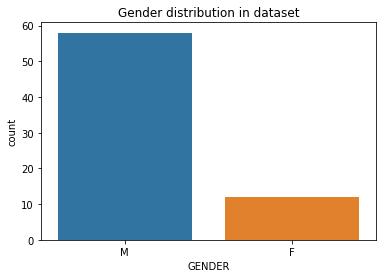

In [624]:
sns.countplot(data=df[['NAME','GENDER']].drop_duplicates(),x='GENDER')
plt.title('Gender distribution in dataset');

Cumulative work hours

In [625]:
# Cumulative work hours per year-month
df_v1=df.groupby(['NAME','YEAR_MONTH'],as_index=False).agg({'WT_HOURS':'sum','MONTH':'median','YEAR':'median'})
df_v1['DAY_ACTIVE']=1
df_v1[['MONTH','YEAR']]=df_v1[['MONTH','YEAR']].astype('int')
#df_v1

In [626]:
# Mean workforce attendance per year-month
df_v2=df.groupby(['NAME','DATE'],as_index=True).agg({'WT_HOURS':(lambda x: 1)}).reset_index().groupby(['DATE'],as_index=False).agg({'WT_HOURS':'count'})
df_v2.rename(columns={'WT_HOURS':'ATTENDANCE'},inplace=True)
df_v2=generate_time_features(df_v2)

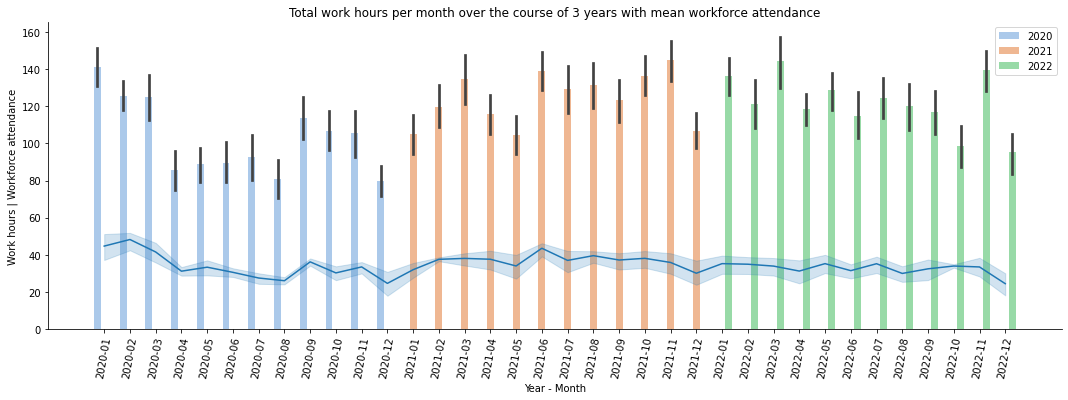

In [627]:
a = sns.catplot(data=df_v1,
            x='YEAR_MONTH',
            y='WT_HOURS',
            kind='bar',
            hue='YEAR',
            height=5,
            aspect=3,
            palette='pastel')
b = sns.lineplot(data=df_v2,
             x='YEAR_MONTH',
             y='ATTENDANCE')
a._legend.remove()
plt.xlabel('Year - Month')
plt.ylabel('Work hours | Workforce attendance')
plt.title('Total work hours per month over the course of 3 years with mean workforce attendance')
plt.xticks(rotation=80);

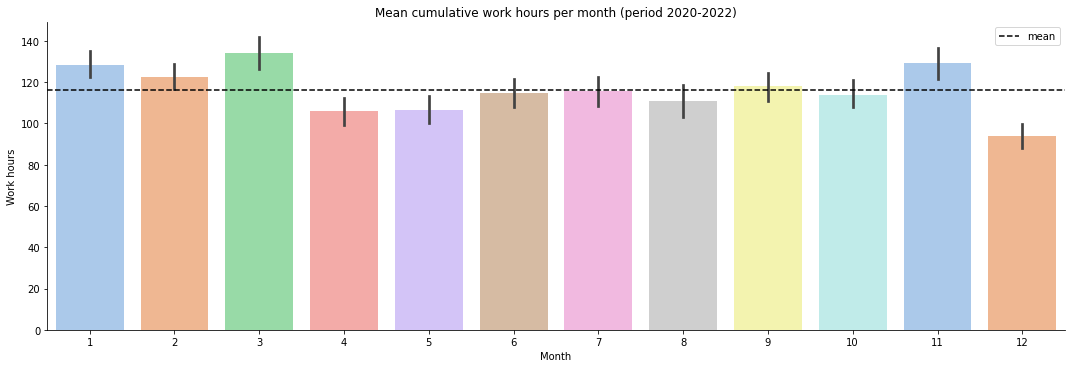

In [628]:
sns.catplot(data=df_v1,
            x='MONTH',
            y='WT_HOURS',
            kind='bar',
            height=5,
            aspect=3,
            palette='pastel')
plt.xlabel('Month')
plt.ylabel('Work hours')
#plt.xticks(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Okt','Nov','Dec'])
plt.axhline(df_v1.groupby('MONTH',as_index=False).agg({'WT_HOURS':'mean'})['WT_HOURS'].mean(),color='black',ls='--',label='mean')
plt.legend()
plt.title('Mean cumulative work hours per month (period 2020-2022)');

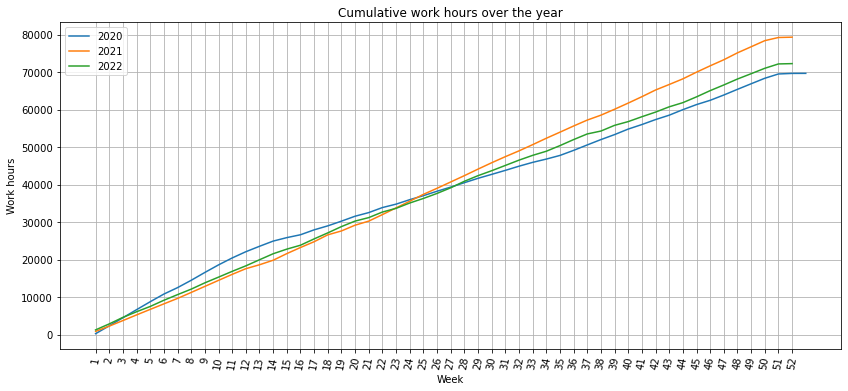

In [629]:
# Cumulative work hours over the course of a year
df_v3=df.groupby(['YEAR_WEEK'],as_index=False).agg({'WT_HOURS':'sum','YEAR':'median','WEEK':'median'})
df_v3[['WEEK','YEAR']]=df_v3[['WEEK','YEAR']].astype('int')

plt.figure(figsize=(14,6))
for i in df_v3['YEAR'].unique():
    sns.lineplot(x=df_v3.loc[df_v3['YEAR']==i]['WEEK'],
                y=df_v3.loc[df_v3['YEAR']==i]['WT_HOURS'].cumsum(),
                 label=i)

plt.xlabel('Week')
plt.ylabel('Work hours')
plt.title('Cumulative work hours over the year')
plt.xticks(range(1,53,1))
plt.legend()
plt.grid()
plt.xticks(rotation=80);

Working hours per weekday

In [630]:
# First add up all working hours per employee per day, then generate mean values per day
df_v4=df.groupby(['NAME','DATE'],as_index=False).agg({'WT_HOURS':'sum','WEEKDAY':'mean'}) \
        .groupby(['DATE'],as_index=False).agg({'WT_HOURS':'mean','WEEKDAY':'mean'})

def translate_weekday(series):
    '''
    Support function for .apply in dt_features
    Translates day of the week into Strings
    '''
    #print(series)
    if series==0:
      return 'Monday'
    elif series==1:
      return 'Tuesday'
    elif series==2:
      return 'Wednesday'
    elif series==3:
      return 'Thursday'
    elif series==4:
      return 'Friday'
    # Not needed in theory because there is no trading on the weekends
    elif series==5:
      return 'Saturday'
    elif series==6:
      return 'Sunday'

df_v4['WEEKDAY_STR']=df_v4['WEEKDAY'].apply(translate_weekday)

Due to low attendance on Saturday and Sunday value spread has a high influence on mean and std


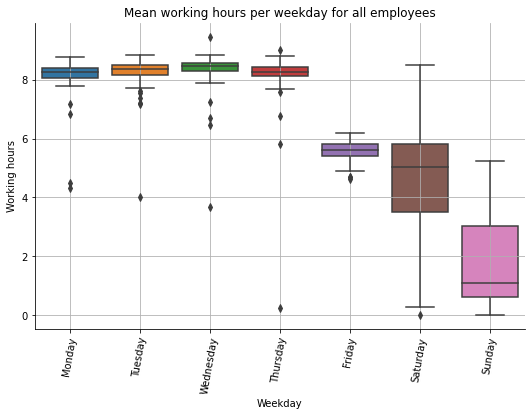

In [631]:
sns.catplot(data=df_v4,x='WEEKDAY_STR',y='WT_HOURS',kind='box',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],height=5,aspect=1.5)
plt.xlabel('Weekday')
plt.ylabel('Working hours')
plt.title('Mean working hours per weekday for all employees')
plt.grid()
plt.xticks(rotation=80);
print('Due to low attendance on Saturday and Sunday value spread has a high influence on mean and std')

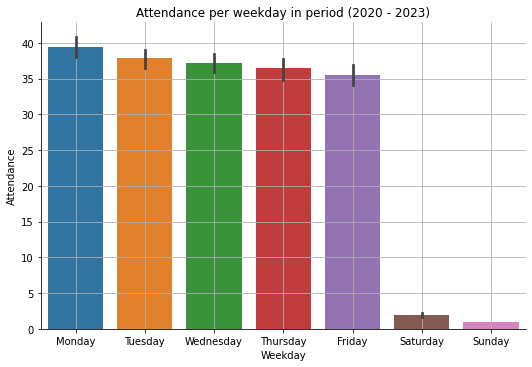

In [632]:
# Employee attendance per weekday; mean over period (2020 - 2022)
df_v5=df_v2.copy()
df_v5['WEEKDAY_STR']=df_v5['WEEKDAY'].apply(translate_weekday)

sns.catplot(data=df_v5,x='WEEKDAY_STR',y='ATTENDANCE',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],kind='bar',height=5,aspect=1.5)
plt.xlabel('Weekday')
plt.ylabel('Attendance')
plt.title('Attendance per weekday in period (2020 - 2023)')
plt.grid();

Data visulualization of single employees

In [878]:
# Selecting random employee
random_name=random.choice(df['NAME'].unique())

Personal overtimes

In [634]:
df_v6=df.groupby(['NAME','DATE'],as_index=False).agg({'IN':'min','OUT':'max','WT_HOURS':'sum'})
df_v6=generate_time_features(df_v6)

In [635]:
# Setting quotas for each weekday
df_v6.loc[df_v6['WEEKDAY']<=3,'QUOTA']=8.5
df_v6.loc[df_v6['WEEKDAY']==4,'QUOTA']=6
df_v6.loc[df_v6['WEEKDAY']>=5,'QUOTA']=0

In [636]:
# Calculating overtimes per employee per day
df_v6['OVERTIME']=df_v6['WT_HOURS']-df_v6['QUOTA']

Yearly overtimes

In [637]:
df_v7=df_v6.groupby(['NAME','YEAR'],as_index=False).sum()[['NAME','YEAR','OVERTIME']]

In and out times per day

In [638]:
# grouping of complete work day per person per day
df_v8=df.loc[(df['WORKTIME']>0) & (df['ACTION']=='0')].groupby(['NAME','DATE'],as_index=False).agg({'IN':'min','OUT':'max','WORKTIME':'sum'})

In [639]:
# Night shift working occurrences
display(df_v8.loc[df_wh['IN']=='2000-01-01 00:00:00'])
display(df_v8.loc[df_wh['OUT']=='2000-01-02 00:00:00'])

,NAME,DATE,IN,OUT,WORKTIME
3965,"Bruce, Brian",2021-09-29,2000-01-01,2000-01-01 06:12:28,332
7934,"Davis, Floyd",2021-06-10,2000-01-01,2000-01-01 02:34:38,154
7948,"Davis, Floyd",2021-06-30,2000-01-01,2000-01-02 00:00:00,789
7949,"Davis, Floyd",2021-07-01,2000-01-01,2000-01-01 03:02:52,182
7971,"Davis, Floyd",2021-08-04,2000-01-01,2000-01-01 06:30:02,360
12638,"Harrison, Richard",2021-06-30,2000-01-01,2000-01-02 00:00:00,897
12639,"Harrison, Richard",2021-07-01,2000-01-01,2000-01-01 03:02:56,182
12669,"Harrison, Richard",2021-08-12,2000-01-01,2000-01-02 00:00:00,798
12670,"Harrison, Richard",2021-08-13,2000-01-01,2000-01-01 12:50:41,725
12673,"Harrison, Richard",2021-08-18,2000-01-01,2000-01-02 00:00:00,773


,NAME,DATE,IN,OUT,WORKTIME
3964,"Bruce, Brian",2021-09-28,2000-01-01 17:46:34,2000-01-02,360
7933,"Davis, Floyd",2021-06-09,2000-01-01 16:21:16,2000-01-02,414
7947,"Davis, Floyd",2021-06-29,2000-01-01 21:48:01,2000-01-02,131
7948,"Davis, Floyd",2021-06-30,2000-01-01 00:00:00,2000-01-02,789
7970,"Davis, Floyd",2021-08-03,2000-01-01 20:52:11,2000-01-02,187
12581,"Harrison, Richard",2021-03-09,2000-01-01 05:00:00,2000-01-02,450
12637,"Harrison, Richard",2021-06-29,2000-01-01 21:48:06,2000-01-02,131
12638,"Harrison, Richard",2021-06-30,2000-01-01 00:00:00,2000-01-02,897
12668,"Harrison, Richard",2021-08-11,2000-01-01 11:03:34,2000-01-02,731
12669,"Harrison, Richard",2021-08-12,2000-01-01 00:00:00,2000-01-02,798


In [640]:
# Filtering out weekend work
df_v8=df_wh.loc[(df_wh['IN']!='2000-01-01 00:00:00') & (df_wh['OUT']!='2000-01-02 00:00:00')]

In [641]:
# Generate markers for late start or early leave
latest_in=dt(2000,1,1,9,0,0)
earliest_out=dt(2000,1,1,15,0,0)

df_v8['LATE_START']=[1 if x > latest_in else 0 for x in df_v8['IN']]
print(df_v8['LATE_START'].sum())

df_v8['EARLY_LEAVE']=[1 if x < earliest_out else 0 for x in df_v8['OUT']]
print(df_v8['EARLY_LEAVE'].sum())

866
7982


In [642]:
# clocking in and out times as float
def calc_timedelta(time):
    zero_time=dt(2000,1,1,0,0,0)
    td=time-zero_time
    return td.seconds/3600

df_v8['IN_HOURS']=df_v8['IN'].apply(calc_timedelta)
df_v8['OUT_HOURS']=df_v8['OUT'].apply(calc_timedelta)

df_v8=generate_time_features(df_v8)
df_v8['WEEKDAY_STR']=df_v8['WEEKDAY'].apply(translate_weekday)

Employee name: Coll, Neil

Mean clocking in time: 07:34:02| (std: 00:38:22)
Mean clocking out time (Mo-Thu): 16:49:05| (std: 00:45:37)
Mean clocking out time (Fr): 13:30:27| (std: 00:50:22)

Clocked in after 09:00 13 times
Clocked out before 15:00 106 times

Yearly overtimes earned by employee
    YEAR   OVERTIME
38  2020 -45.716667
39  2021   9.683333
40  2022  24.516667


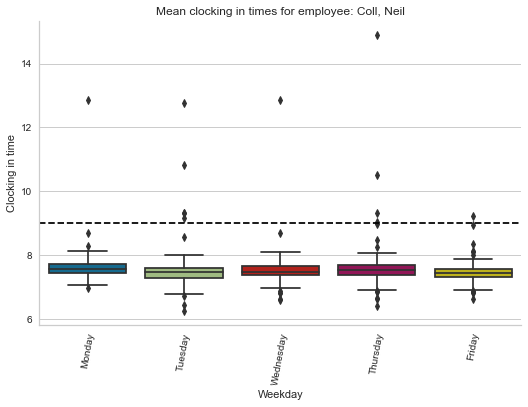

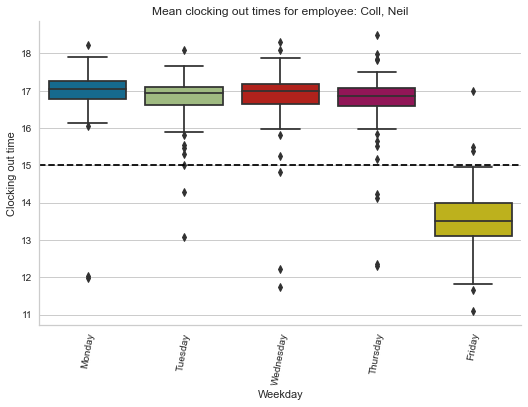

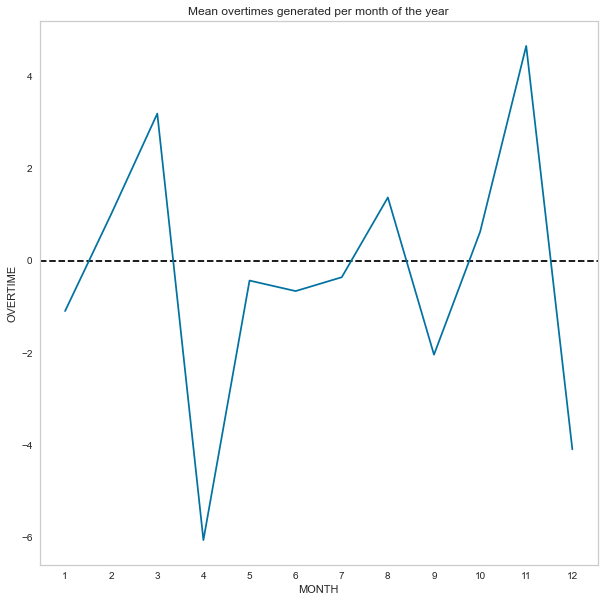

In [879]:
def generate_timestamp(time):
    hour=int(time // 1)
    minute=((time - hour)*60)//1
    second=((time-hour-(minute/60))*3600)//1
    timestamp=str(int(hour)).zfill(2) + ':' + str(int(minute)).zfill(2) + ':' + str(int(second)).zfill(2)
    return timestamp

def show_empl_info(random_name):
    # General info
    late_start=df_v8.loc[df_wh['NAME']==random_name]['LATE_START'].sum()
    early_leave=df_v8.loc[df_wh['NAME']==random_name]['EARLY_LEAVE'].sum()
    print('Employee name: {}'.format(random_name))
    mcit=generate_timestamp(df_v8.loc[df_v8['NAME']==random_name]['IN_HOURS'].mean())
    stdcit=generate_timestamp(df_v8.loc[df_v8['NAME']==random_name]['IN_HOURS'].std())
    print(f'\nMean clocking in time: {mcit}| (std: {stdcit})')

    mcot_m_t=generate_timestamp(df_v8.loc[(df_v8['NAME']==random_name) & (df_v8['WEEKDAY']<=3)]['OUT_HOURS'].mean())
    stdcot_m_t=generate_timestamp(df_v8.loc[(df_v8['NAME']==random_name) & (df_v8['WEEKDAY']<=3)]['OUT_HOURS'].std())
    print(f'Mean clocking out time (Mo-Thu): {mcot_m_t}| (std: {stdcot_m_t})')

    mcot_f=generate_timestamp(df_v8.loc[(df_v8['NAME']==random_name) & (df_v8['WEEKDAY']==4)]['OUT_HOURS'].mean())
    stdcot_f=generate_timestamp(df_v8.loc[(df_v8['NAME']==random_name) & (df_v8['WEEKDAY']==4)]['OUT_HOURS'].std())
    print(f'Mean clocking out time (Fr): {mcot_f}| (std: {stdcot_f})')
    print(f'\nClocked in after 09:00 {late_start} times')
    print(f'Clocked out before 15:00 {early_leave} times')
    print('\nYearly overtimes earned by employee')
    print(df_v7.loc[(df_v7['NAME']==random_name)][['YEAR','OVERTIME']])

    # Clocking in hours
    sns.catplot(data=df_v8.loc[(df_v8['NAME']==random_name) & (df_v8['WEEKDAY']<=4)],x='WEEKDAY_STR',y='IN_HOURS',kind='box',order=['Monday','Tuesday','Wednesday','Thursday','Friday'],height=5,aspect=1.5)
    plt.xlabel('Weekday')
    plt.ylabel('Clocking in time')
    title='Mean clocking in times for employee: ' + random_name
    plt.title(title)
    plt.axhline(9,color='black',ls='--')
    plt.xticks(rotation=80);

    # Clocking out hours
    sns.catplot(data=df_v8.loc[(df_v8['NAME']==random_name) & (df_v8['WEEKDAY']<=4)],x='WEEKDAY_STR',y='OUT_HOURS',kind='box',order=['Monday','Tuesday','Wednesday','Thursday','Friday'],height=5,aspect=1.5)
    plt.xlabel('Weekday')
    plt.ylabel('Clocking out time')
    title='Mean clocking out times for employee: ' + random_name
    plt.title(title)
    plt.axhline(15,color='black',ls='--')
    plt.xticks(rotation=80);

    # Lineplot of mean overtimes generated per Month
    df_lp=df_v6.groupby(['NAME','YEAR_MONTH'],as_index=False).agg({'MONTH':'median','OVERTIME':'sum'}).groupby(['NAME','MONTH'],as_index=False).mean()
    plt.figure(figsize=(10,10))
    plt.xticks(range(1,13,1))
    plt.axhline(0,color='black',ls='--')
    plt.grid()
    plt.title('Mean overtimes generated per month of the year')
    sns.lineplot(data=df_lp.loc[df_lp['NAME']==random_name],x='MONTH',y='OVERTIME');
    
show_empl_info(random_name)

# Step 4
Setting up a clustering algorithm

In [770]:
# Import libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer

Creating Dataset by feature engineering  
Since Friday times differ from the rest of the week, only times Monday through Thursday are used

In [893]:
# grouping of complete work day per person per day
df_cluster=df.loc[(df['WORKTIME']>0) & (df['ACTION']=='0')].groupby(['NAME','DATE'],as_index=False).agg({'IN':'min','OUT':'max','WORKTIME':'sum'})

In [897]:
# Checking for sufficient representation of each name
df_cluster['NAME'].value_counts()

Blaine, Josef      641
Scudder, Thomas    636
Snyder, Kevin      635
Barrett, Joseph    632
Adams, Beth        629
                  ... 
Mitchell, Fred      53
Lavoie, Mike        42
Murillo, Lisa       33
Stewart, George     22
Wells, Camille       2
Name: NAME, Length: 70, dtype: int64

Wells, Camille is severely under-represented and will be deleted from dataset

In [898]:
df_cluster=df_cluster.loc[df_cluster['NAME']!='Wells, Camille']

In [899]:
# Clocking in and out times
df_cluster['IN_HOURS']=df_cluster['IN'].apply(calc_timedelta)
df_cluster['OUT_HOURS']=df_cluster['OUT'].apply(calc_timedelta)

# Adding time features
#df_cluster=generate_time_features(df_cluster).drop(['YEAR_MONTH','YEAR_WEEK'],axis=1)
df_cluster['WEEKDAY']=df_cluster['DATE'].dt.weekday
df_cluster=df_cluster.loc[df_cluster['WEEKDAY']<=3]
#df_cluster['DAY']=df_cluster['DATE'].dt.day

# Dropping dates
df_cluster.drop(['DATE','IN','OUT'],axis=1,inplace=True)
# Firstly group by NAME & WEEKDAY
df_cluster=df_cluster.groupby(['NAME','WEEKDAY'],as_index=False).mean()
# Secondly group by NAME only, generate MEAN and STD
df_cluster=df_cluster.groupby('NAME',as_index=False).agg({'WORKTIME':['mean','std'],'IN_HOURS':['mean','std'],'OUT_HOURS':['mean','std']})
# Flatten of columns
df_cluster.columns = [f"{x}{y}" for x, y in df_cluster.columns.to_flat_index()]


name_gender=df[df[['NAME','GENDER']].duplicated()==False][['NAME','GENDER']]

# Recovering gender
def translate_name(name):
    return name_gender.loc[name_gender['NAME']==name]['GENDER'].iloc[0]

df_cluster['GENDER']=df_cluster['NAME'].apply(translate_name)

In [900]:
# Label Encoding
le=LabelEncoder()
df_cluster['NAME']=le.fit_transform(df_cluster['NAME'])

l2=LabelEncoder()
df_cluster['GENDER']=l2.fit_transform(df_cluster['GENDER'])

df_cluster

,NAME,WORKTIMEmean,WORKTIMEstd,IN_HOURSmean,IN_HOURSstd,OUT_HOURSmean,OUT_HOURSstd,GENDER
0,0,531.430845,3.493188,6.410136,0.071928,15.998596,0.040249,0
1,1,510.341294,14.805968,6.973555,0.259338,16.225643,0.190180,1
2,2,523.715046,10.121396,7.074762,0.027976,16.610245,0.181120,1
3,3,501.510328,6.834236,7.124942,0.038295,16.145577,0.150313,1
4,4,535.068688,4.357106,6.063734,0.024847,15.731534,0.072130,1
...,...,...,...,...,...,...,...,...
64,64,544.084032,6.089058,6.574665,0.022992,16.388668,0.130620,1
65,65,471.845747,8.445603,6.032628,0.124232,14.626079,0.125841,1
66,66,511.130750,8.179889,7.446911,0.091153,16.715701,0.078645,1
67,67,507.487908,2.675183,6.137230,0.023714,15.422153,0.040840,1


Plotting Dendrogram

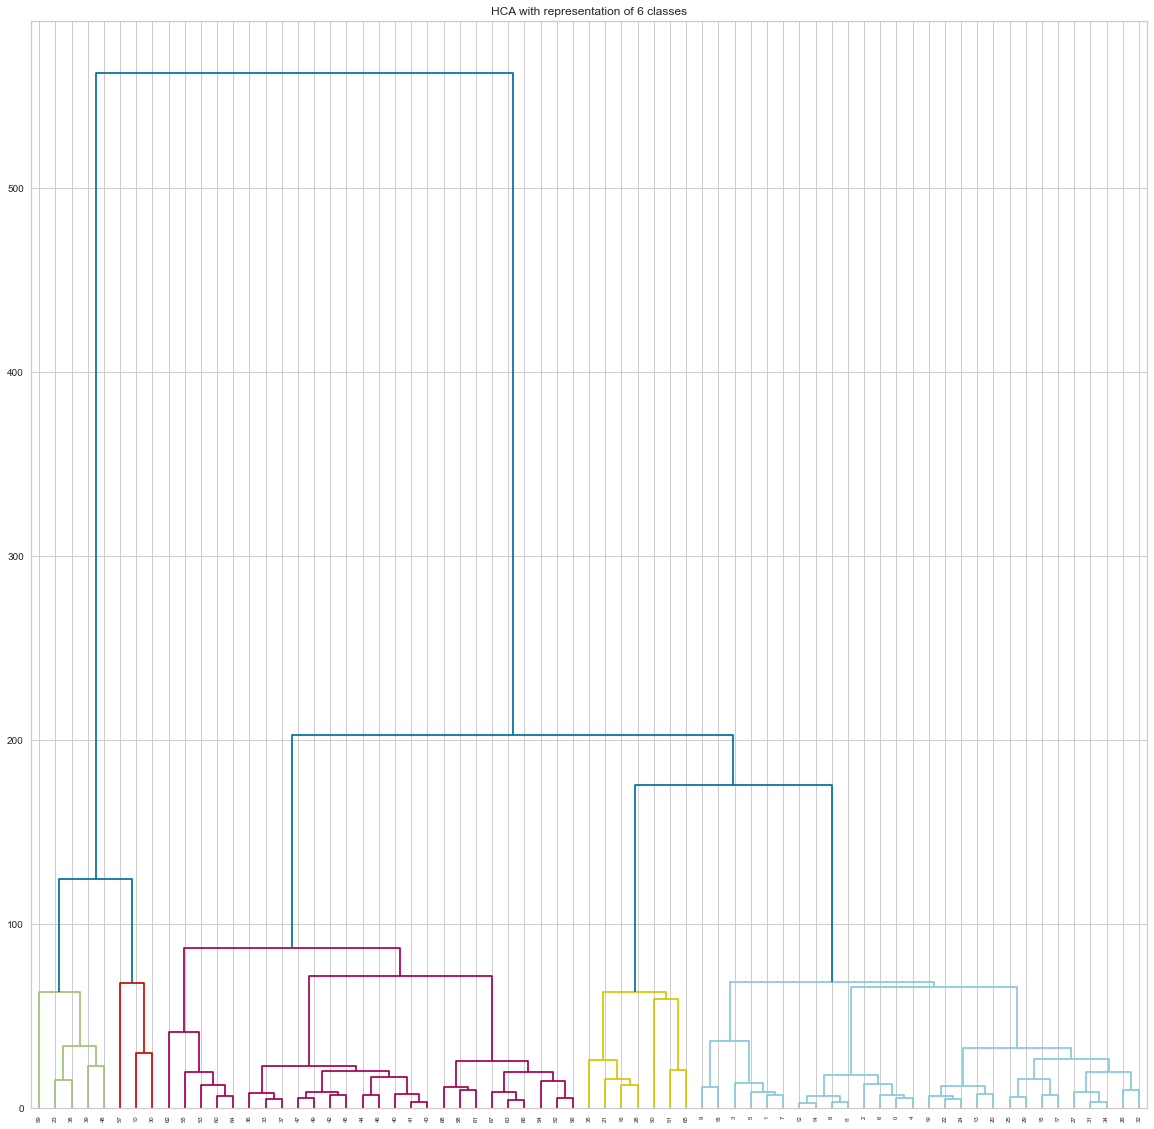

In [901]:
Z = linkage(df_cluster, method='ward', metric='euclidean');
plt.figure(figsize=(20,20));
plt.title('HCA with representation of 6 classes')
dendrogram(Z, labels=df_cluster.index,leaf_rotation=90,color_threshold=100);

For the fist try clustering for 5 clusters will be performed

In [903]:
clf=AgglomerativeClustering(n_clusters=5)
clf.fit(df_cluster)
labels=clf.labels_

In [904]:
from sklearn.metrics import silhouette_score
sc=silhouette_score(df_cluster,labels,metric='sqeuclidean')
print('Silhouette Score: {0:.3f}'.format(sc))

Silhouette Score: 0.622


Finding best number of clusters with highest separating value

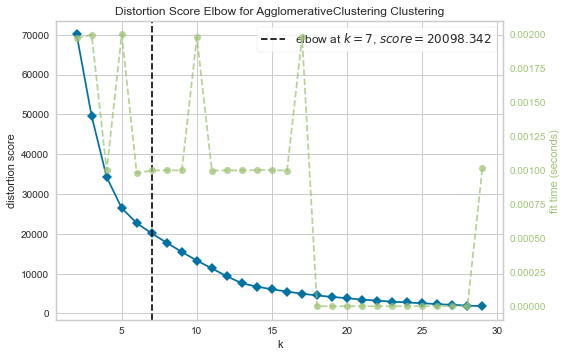

In [905]:
# Elbow Method

clf = AgglomerativeClustering()

visualizer = KElbowVisualizer(clf, k=(2,30), timings= True)
visualizer.fit(df_cluster)
visualizer.show();

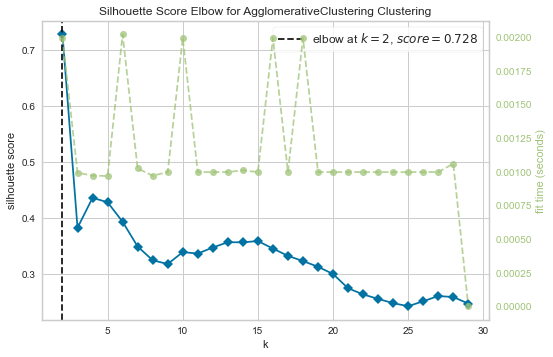

In [906]:
# Silhouette Score
clf = AgglomerativeClustering()

visualizer = KElbowVisualizer(clf, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(df_cluster)
visualizer.show();

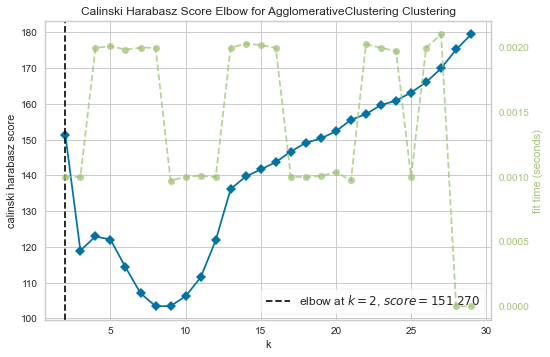

In [907]:
# Calinski Harabasz Score
clf = AgglomerativeClustering()

visualizer = KElbowVisualizer(clf, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(df_cluster)
visualizer.show();

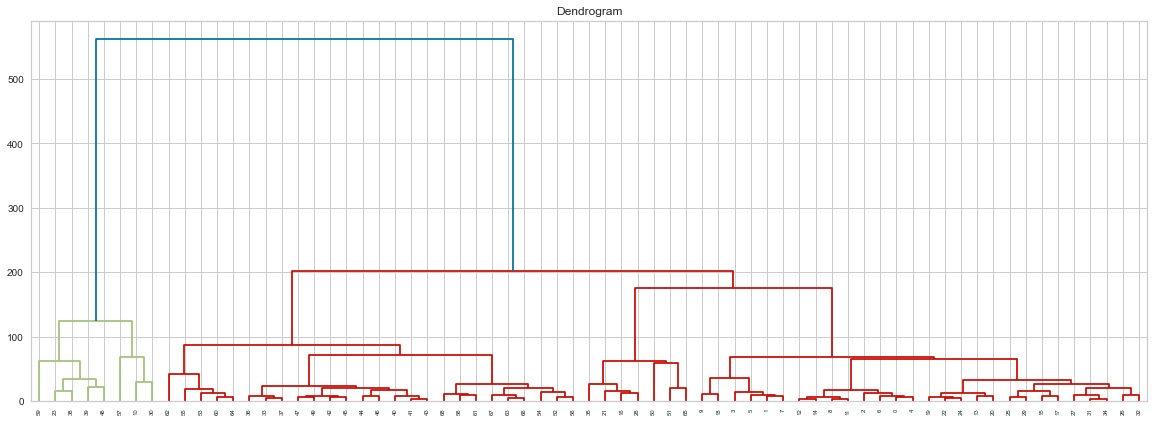

In [908]:
# Dendogram for Heirarchical Clustering
plt.figure(figsize=(20, 7))  
plt.title("Dendrogram")  
dendrogram(shc.linkage(df_cluster, method='ward'));

The best number for clustering is either 2 or 3. We go for 2

In [909]:
clf=AgglomerativeClustering(n_clusters=2)
clf.fit(df_cluster)
labels=clf.labels_

In [910]:
results=df_cluster.copy()
results['GENDER']=l2.inverse_transform(results['GENDER'])
results['NAME']=le.inverse_transform(results['NAME'])
#results.append(pd.Series(labels))
results['CLUSTER']=pd.Series(labels)
results

,NAME,WORKTIMEmean,WORKTIMEstd,IN_HOURSmean,IN_HOURSstd,OUT_HOURSmean,OUT_HOURSstd,GENDER,CLUSTER
0,"Adams, Beth",531.430845,3.493188,6.410136,0.071928,15.998596,0.040249,F,0
1,"Agnew, William",510.341294,14.805968,6.973555,0.259338,16.225643,0.190180,M,0
2,"Alejandro, Brian",523.715046,10.121396,7.074762,0.027976,16.610245,0.181120,M,0
3,"Anderson, Robert",501.510328,6.834236,7.124942,0.038295,16.145577,0.150313,M,0
4,"Antal, Rigoberto",535.068688,4.357106,6.063734,0.024847,15.731534,0.072130,M,0
...,...,...,...,...,...,...,...,...,...
64,"Swartout, Federico",544.084032,6.089058,6.574665,0.022992,16.388668,0.130620,M,0
65,"Tarrant, Guillermo",471.845747,8.445603,6.032628,0.124232,14.626079,0.125841,M,0
66,"Tennant, Mitchell",511.130750,8.179889,7.446911,0.091153,16.715701,0.078645,M,0
67,"Winkler, Hugh",507.487908,2.675183,6.137230,0.023714,15.422153,0.040840,M,0


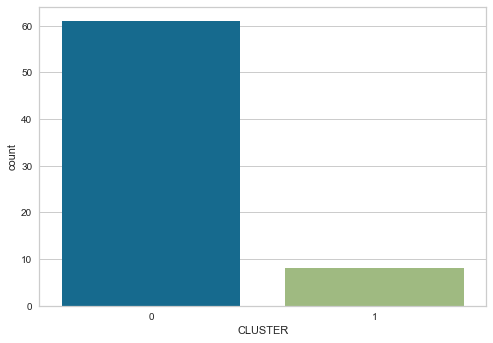

In [911]:
sns.countplot(data=results,x='CLUSTER');

,CLUSTER,WORKTIMEmean,WORKTIMEstd,IN_HOURSmean,IN_HOURSstd,OUT_HOURSmean,OUT_HOURSstd
0,0,516.053078,9.178323,6.760801,0.096025,16.080148,0.155511
1,1,366.931873,19.735035,7.607002,0.190523,14.231540,0.476368


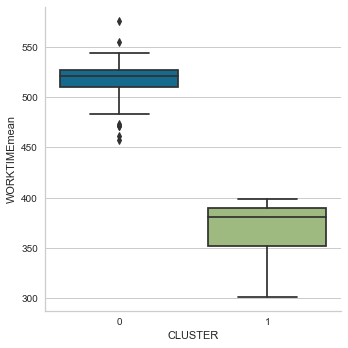

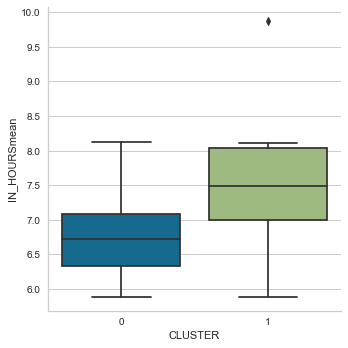

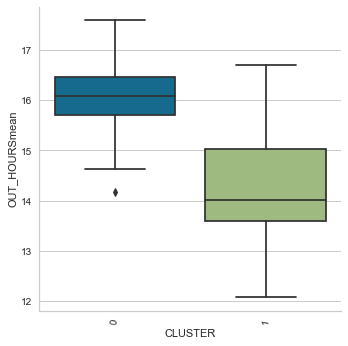

In [937]:
sns.catplot(data=results,x='CLUSTER',y='WORKTIMEmean',kind='box')
sns.catplot(data=results,x='CLUSTER',y='IN_HOURSmean',kind='box')
sns.catplot(data=results,x='CLUSTER',y='OUT_HOURSmean',kind='box');
plt.xticks(rotation=80)
display(results.groupby(['CLUSTER'],as_index=False).mean())

Showing the influence of each feature to cluster representation

<AxesSubplot:>

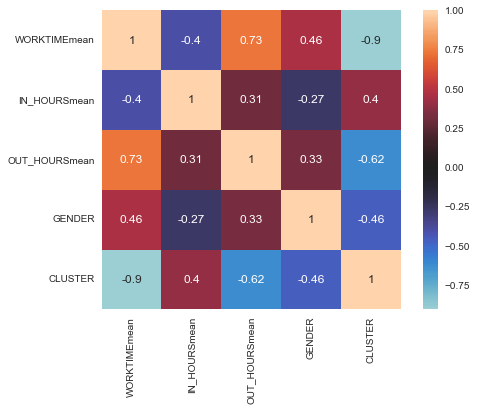

In [944]:
r_hm=results[['WORKTIMEmean','IN_HOURSmean','OUT_HOURSmean','GENDER','CLUSTER']]
r_hm['GENDER']=l2.transform(results['GENDER'])
sns.heatmap(r_hm.corr(),annot=True,center=0,square=True)

# Step 4
Conclusion

The dataset could be clustered into two groups, showing different clocking in and out times and total work hours.  
It could also be observed, that employees of cluster 0 usually start earlier than cluster 1, probably to fit in longer work hours.  
Cluster 0 outweighs cluster 1 by roughly 6:1. This rouhgly depicts the gender distribution. The heatmap shows, that the strongest influence is mean WORKTIME.